In [5]:
!pip install pandas numpy requests shap tensorflow folium streamlit_folium


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.5/328.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.3 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
import requests
import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import folium
from streamlit_folium import folium_static
import matplotlib.pyplot as plt


2025-02-15 07:25:47.831 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [8]:

data = pd.read_csv("Crop_recommendation.csv")
data.head()


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [9]:
# Feature Selection
X = data.drop(columns=['label'])  # All features except the target crop label
y = data['label']  # Target variable

# Encode Target Variable
y = pd.factorize(y)[0]  # Convert categorical labels to numerical values

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [10]:
# ANN Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(set(y)), activation='softmax')  # Output layer for multi-class classification
])

# Compile Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=16)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1833 - loss: 2.8442 - val_accuracy: 0.6614 - val_loss: 1.6512
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6303 - loss: 1.4737 - val_accuracy: 0.7636 - val_loss: 0.7433
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7337 - loss: 0.8547 - val_accuracy: 0.8705 - val_loss: 0.4729
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7984 - loss: 0.6088 - val_accuracy: 0.8795 - val_loss: 0.3687
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7970 - loss: 0.5406 - val_accuracy: 0.9205 - val_loss: 0.2974
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8308 - loss: 0.4491 - val_accuracy: 0.9227 - val_loss: 0.2574
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8638 - loss: 0.3968 - val_accuracy: 0.9273 - val_loss: 0.2324
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8710 - loss: 0.3447 - val_accuracy: 0.9341 - va

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9699 - loss: 0.0880 
Test Accuracy: 0.9682
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy: 0.9682
F1 Score: 0.9687
Precision: 0.9720
Recall: 0.9682


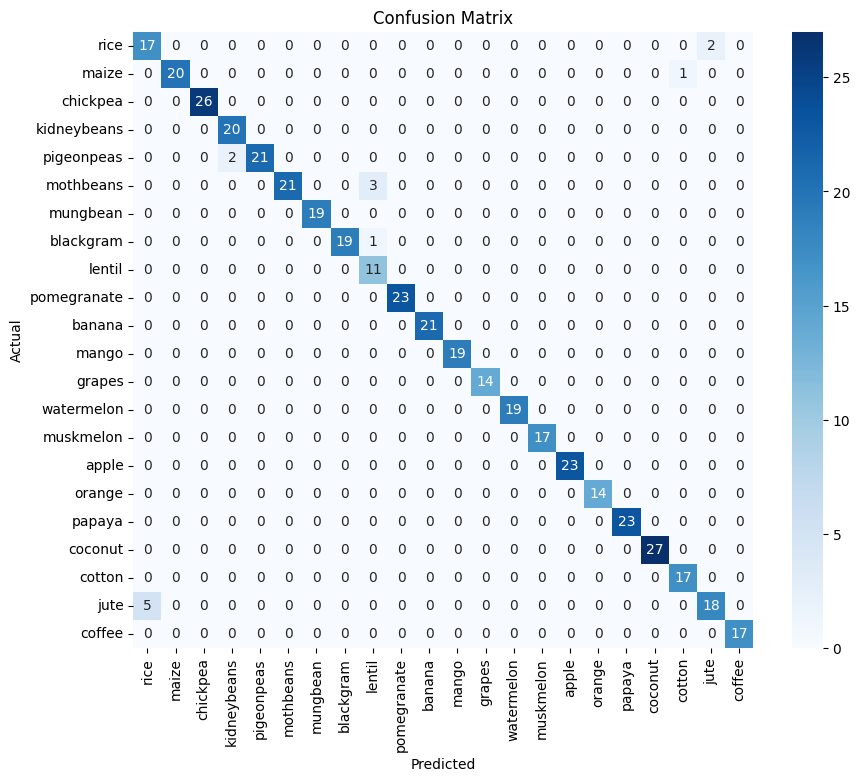

ExactExplainer explainer: 1761it [00:51, 27.48it/s]                          


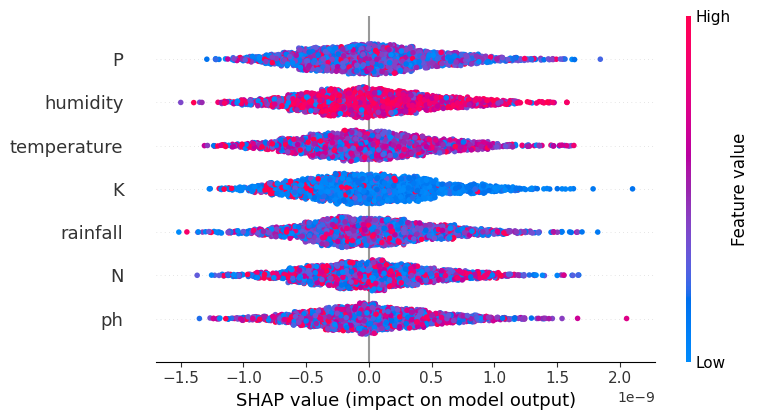

In [18]:
import seaborn as sns
# Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Predictions for Evaluation Metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Calculate Evaluation Metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

accuracy = accuracy_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes, average='weighted')
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=data['label'].unique(), yticklabels=data['label'].unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# SHAP Analysis (Feature Importance)
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)
shap_values_avg = shap_values.values.mean(axis=2)
# Plot Feature Importance
shap.summary_plot(shap_values_avg, X_train, feature_names = X.columns)

In [20]:
def get_weather_data(latitude, longitude):
    # Updated NASA POWER API URL
    url = f"https://power.larc.nasa.gov/api/temporal/daily/point?parameters=T2M,RH2M,PRECTOTCORR&community=AG&longitude={longitude}&latitude={latitude}&start=20230101&end=20230101&format=JSON"

    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        data = response.json()

        # Extract weather data
        temp = data['properties']['parameter']['T2M']['20230101']  # Temperature
        humidity = data['properties']['parameter']['RH2M']['20230101']  # Humidity
        rainfall = data['properties']['parameter']['PRECTOTCORR']['20230101']  # Precipitation

        return temp, humidity, rainfall
    except requests.exceptions.RequestException as e:
        print(f"Error fetching weather data: {e}")
        return None

# Example Call
lat, lon = 20.5937, 78.9629  # Coordinates for India
weather = get_weather_data(lat, lon)
if weather:
    print(f"Weather Data: Temp={weather[0]}°C, Humidity={weather[1]}%, Rainfall={weather[2]}mm")
else:
    print("Failed to fetch weather data.")

Weather Data: Temp=19.19°C, Humidity=65.87%, Rainfall=0.0mm


In [21]:
def predict_crop(input_data):
    input_data = np.array(input_data).reshape(1, -1)
    input_data = scaler.transform(input_data)
    prediction = model.predict(input_data)
    predicted_label = np.argmax(prediction)
    return data['label'].unique()[predicted_label]

# Example Usage
sample_input = X_test[0]
predicted_crop = predict_crop(sample_input)
print(f"Recommended Crop: {predicted_crop}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Recommended Crop: mothbeans


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
